In [1]:
from __future__ import division
import os, sys, time, random
import math
import scipy
from scipy import constants
import torch
from torch import nn, optim
from torch import autograd
from torch.autograd import grad
import numpy as np
#import autograd.numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from torch.nn import functional as F
from scipy.constants import pi
import scipy.integrate as integrate
import scipy.special as special
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Lithium
ENERGY = -7.477487
Lithium_Atom={
#key=l
#[j,n,z]
'exponents':{0: [[1, 1, 2.47673], [2, 1, 4.69873], [3, 2, 0.3835], [4,2, 0.66055], [5, 2, 1.07],
                 [6,2, 1.632], [7,1, 12.87], [8,3, 3.99], [9, 3, 2.5], [10, 4, 8.0], 
                 [11, 4, 4.6], [12, 4, 0.85]], 
             1: [[1, 2, 3.92], [2, 2, 1.34], [3, 3, 4.6], [4, 3, 3.7], [5,4, 8.78], [6, 4, 4.5]],
             2: [[1, 3,5.68], [2,3, 2.56], [3,4, 6.37],[4, 4, 2.55],[5,5,7.07], [6,5, 2.84]], 
             3: [[1,4, 7.5], [2,4, 2.5], [3,5, 8.23], [4,6, 8.96]]},
#
#l:{i:[[j1,...,JN],Occ]}
#
'coefficientsA':{0: {1: [[-0.07022964, -0.0015536, -0.00044257, 1.0110744, 0.08297592, -0.07879881, -2.515e-05, 0.00288456, -0.0106365, -8.58e-06, -0.00225377, -0.02234625], 0.99949377],
                     2: [[0.89214085, 0.12203101, -0.00031654, -0.08090132, -0.02703011, 0.03099852, -0.00058341, 0.01750594, -0.00365969, -0.00122279, -0.01072443, -0.00451589], 0.99662928],
                     3: [[-2.20482444, 0.26966923, 0.00851532, -0.81124844, 0.6317626000000001, -0.93072732, -0.02450499, 2.70596963, 1.07930331, 0.01085722, -0.69913404, 0.23198173], 0.00133816], 
                     4: [[0.92081082, 0.79928189, 0.02646886, -1.77099574, 1.79162602, -2.49871066, -0.037449199999999995, -2.8674046000000004, 2.41766529, -1.0435101, 1.93814761, 0.61870719], 2.936e-05], 
                     5: [[43.17308932, -22.99004495, -0.10282826, 7.75738142, -9.72275132, 11.51026798, 1.19210194, -54.55577484, -7.31868548, 3.5961727999999997, 25.89986262, -3.67948961], 2.88e-06], 
                     6: [[112.5262685, -58.23472448, -0.06353453, 18.19517428, -19.33029919, 19.59911206, 3.10485082, -117.8611399, -20.34292568, -0.57949238, 57.11052849, -8.184094199999999], 5.99e-07],
                     7: [[60.08406468, -34.68555237, -0.31796783, -2.23020879, -0.93199429, 11.2845511, 2.2468387, 77.60297499, -15.26902052, -32.74176591, -82.32209350000001, 1.46996135], 1.31e-07], 
                     8: [[-71.96740129, 37.71080209, 2.48402982, -149.5917608, 177.86479369999998, -206.6997706, -2.60699372, 262.0290645, 118.7415503, -31.66277201, -185.5884122, 66.08712343], 3.47e-08], 
                     9: [[-18.87210056, 13.01124436, 4.48561615, -108.61148440000001, 134.3748878, -148.19966269999998, -1.48395064, 61.27754378, 74.39217804, -2.72979772, -37.42322805, 43.43261588], 1.18e-08],
                     10:[[66.42794187, -41.72827346, -0.31212102, 280.116038, -309.1710792, 291.8523659, 4.26550091, -128.0713149, -140.0164268, 1.34455698, 68.86951963, -129.50509509999998], 5.1200000000000005e-09], 
                     11:[[317.450537, -117.0557815, 1.18523378, -139.4857445, 156.2191775, -146.51852780000002, 15.40292948, -9.27798888, 41.10059012, -56.74017783, -99.93648644, 63.20967831], 2.43e-09], 
                     12: [[21.12068708, -6.12007443, 2.19571677, -304.5286359, 317.4671671, -261.0224935, -0.43866542, 43.34604911, 105.11236159999999, -3.38266586, -28.91989599, 142.036002], 8.530000000000001e-10]}, 
                 1: {1: [[0.59287297, -0.00747611, 0.09934888, 0.79189506, 0.03278115, -0.50989564], 0.0006157], 
                     2: [[-0.35591914, 1.32635432, 0.2583241, -2.01066787, 0.07738288, 1.312673], 0.00014156], 
                     3: [[-2.06071044, -1.21299972, -0.06093124, 9.22235028, -1.01763444, -5.49165753], 2.789e-05], 
                     4: [[-4.18090925, 1.29915126, 12.06996543, -11.43927604, -0.70651815, 3.13502736], 4.21e-06], 
                     5: [[-8.54359437, -1.13581296, -2.8536675, 24.48578178, 3.70866652, -16.08874468], 5.71e-07], 
                     6: [[1.42542975, 2.06435622, -8.66345944, -82.3936089, 15.55471538, 77.66919395], 1.32e-07]}, 
                 2:{1: [[0.26768469, 0.22718279, 0.88327198, 0.08055751, -0.29220148, -0.15405494], 1.75e-05], 
                    2: [[0.04142718, -5.17781027, -1.09004698, 13.66165079, 1.31277395, -8.2331428], 3.9e-06], 
                    3: [[-1.96866987, 9.20053442, -1.70271348, -19.87132284, 2.30293627, 11.59394209], 1.64e-06], 
                    4: [[-3.53077363, -14.56772181, 5.57587431, 25.8633599, 1.23639269, -14.12794416], 4.03e-07], 
                    5: [[18.40621154, -13.90792651, -41.38177032, 26.48192709, 26.72269899, -15.41123519], 9.140000000000001e-08], 
                    6: [[-0.16832219, 67.45111750000001, -12.09561956, -174.91175149999998, 4.77388709, 116.2950341], 1.86e-08]}, 
                 3: {1: [[0.36104445, 0.18436985, 0.21835383, 0.3560076], 1.82e-06], 
                     2: [[0.01260681, 0.95875728, -1.77368916, 1.29832907], 5.5e-07], 
                     3: [[-0.86486813, -0.51206662, -4.58912079, 5.71419746], 2.3e-07], 
                     4: [[21.4270521, -0.25541042, -46.13810929, 25.43946293], 3.18e-08]}},
'coefficientsB':{0:{1:[[0.87740161, 0.12097415, -0.0004273, 0.01433644, -0.01777707, 0.02216473, -0.00059379, 0.01922058, 0.00010829, -0.00115367, -0.01017498, -0.00594425], 0.99643736],
                    2:[[-2.24945878, 0.28834679999999996, 0.00782288, -0.4902495, 0.61285617, -0.87341476, -0.02503581, 2.7299536, 1.01021286, 0.01024293, -0.75267299, 0.21359615], 0.00133217], 
                    3:[[0.28660926, 1.05420956, 0.02188646, -0.74216062, 0.99612086, -1.48141985, -0.04588767, -1.93046969, 1.84127707, -1.05439224, 1.24269523, 0.30331942], 3.047e-05], 
                    4: [[29.12790646, -15.92193591, -0.1125118, 9.21349678, -10.87679763, 13.00148087, 0.83995487, -37.35668065, -7.47997774, 2.90834175, 17.03785617, -4.10298359], 3.79e-06], 
                    5: [[-111.5020628, 57.68234071, 0.04481586, -15.65696416, 17.12033573, -17.33255529, -3.05308123, 120.7461187, 18.08730897, -0.80452546, -58.89819891, 7.2897896], 7.39e-07], 
                    6: [[65.84508208, -37.45035591, -0.26380573, -7.03264966, 5.17247751, 4.2046505, 2.35600537, 73.2866099, -12.41788582, -32.86571204, -80.28438212, 3.82214918], 1.32e-07], 
                    7: [[76.85091338, -40.08586936, -2.40761735, 144.7356894, -171.798554, 199.5715063, 2.72168017, -264.9789531, -115.63725590000001, 31.50578147, 186.6989115, -63.66646001], 3.1299999999999996e-08], 
                    8: [[-21.00141533, 13.47086447, 3.83442156, -64.51569976, 86.30847022, -107.0662801, -1.4007938999999998, 48.88669481, 57.62594949, -1.25177357, -28.79426581, 24.37142226], 1.26e-08], 
                    9: [[44.8619773, -29.76083989, -2.2906197999999995, 257.1875188, -286.2461151, 269.51966969999995, 3.29041637, -103.2255202, -126.1217895, 1.5887045, 56.31495754, -115.83163770000002], 5.6399999999999995e-09], 
                   10: [[315.0222632, -176.602405, 1.53421696, -73.33031887, 83.96767001, -78.69594316, 15.47325027, -36.11084124, 9.75558502, -53.44780081, -79.74992544, 31.83360267], 2.502e-09], 
                   11: [[-62.96177849, 31.50868654, 0.0867091, 267.3285514, -290.8697747, 268.1509919, -2.2572757, -85.08198592, -117.2487697, 19.62872344, 81.02102229, -125.47917369999999], 1.26e-09], 
                   12: [[11.23298268, -1.65410004, 2.12911756, -238.23488219999996, 244.8381103, -193.8976626, -0.67341194, 22.96267705, 75.49952238, 0.17186182, -11.63671793, 111.2240936], 9.54e-11]}, 
                    1:{1:[[0.5795252, 0.01221482, 0.07903055, 0.82597799, 0.03079253, -0.51854558], 0.00063451], 
                       2: [[-1.4926511, 0.12032034, -0.39728197, 5.41683813, -0.60336845, -3.04484007], 4.788e-05], 
                       3: [[3.7163614000000003, 0.27780156, -8.45758838, 3.42228292, 1.07558177, 0.38700046], 6.82e-06], 
                       4: [[8.26050417, -0.25679009, -3.31035542, -15.59561109, -2.28897287, 13.38144451], 7.48e-07], 
                       5: [[-1.40393545, -0.01436857, -12.06380583, -45.43322127, 13.27075909, 49.37813289], 1.82e-07], 
                       6: [[-3.26254071, -3.21124963, 0.88010412, 72.5238022, -8.6238545, -60.8799509], 1.99e-08]}, 
                 2: {1: [[0.27641572, 0.0494067, 0.85284998, 0.56164749, -0.26345688, -0.44899372], 1.7899999999999998e-05],
                     2: [[-0.85521645, 1.11270971, -1.93402181, -0.09096187, 2.10717966, -0.15986962], 2.71e-06], 
                     3: [[-2.79890036, -1.41219595, 1.13611434, -0.58069064, 2.71593175, 0.69198508], 7.15e-07], 
                     4: [[-14.17750627, 4.98794068, 30.66636569, -14.76028725, -17.51492644, 10.85306156], 1.3e-07], 
                     5: [[11.07987881, 14.90086218, -30.79659634, -51.36034331, 20.29973764, 37.56710748], 4.79e-08], 
                     6: [[-4.77758389, 69.40218571, -0.31309212, -172.3062142, -3.84651548, 112.40144699999999], 5.41e-10]}, 
                 3: {1: [[0.33226321, 0.12012557, 0.19366379, 0.43895715], 1.64e-06], 
                     2: [[0.08789083, 0.72452201, -4.01824892, 3.63584896], 3.5899999999999997e-07], 
                     3: [[1.3619454, 0.81144827, 2.56008258, -4.26627599], 1.67e-07], 
                     4: [[21.40149649, -0.28782613, -46.15453344, 25.49544145], 3e-08]} 
                }}   
    

In [3]:
#Beryllium
ENERGY =  - 14.666902

Beryllium_Atom={
#key=l
#[j,n,z]
'exponents':{0:[[1,1,3.47116],[2,1,6.36861],[3,2,0.7782],[4,2,0.94067],[5,2,1.48725],[6,2,2.7183],[7,1,19.10245],[8,3,1.7],[9,4,1.9]],
1:[[1,2,1.05],[2,3,2.6],[3,4,2.5],[4,5,2.4],[5,6,2.5],[6,2,5.38]], 
2:[[1,3,1.05],[2,4,1.6],[3,5,2.5],[4,6,2.8]],
3:[[1,4,1.65]]},
#
#l:{i:[[j1,...,JN],Occ]}
#
'coefficients':{0:{1:[[0.91186553,0.09133049,-0.00353371,-0.00199010,-0.22454084,0.06699257,-0.00017246,0.26848126,-0.09469250],0.99813124],
2:[[-0.16179804,-0.01625841,0.06166834,0.76021241,0.48896867,-0.15688839,0.00012449,-0.27594922,0.10994351],0.91040966],
3:[[0.75251937,0.00611808,0.77541132,0.79254081,26.22424192,-7.22902112,-0.01055424,-33.62542443,11.22470810],0.00185959],
4:[[-1.65919883,-0.27394103,-0.29717354,2.68813847,-86.29727988,24.06010516,0.05947123,98.38093719,-32.76781481],0.00048798],  
5:[[8.09990971,-4.89675032,-0.51319239,-2.45138493,95.87927298,-28.73571410,0.18791239,-112.5259423,39.99182796],0.00002073],
6:[[-19.93964103,10.22935499,-4.17578448,7.34322229,-410.9667193,118.4810608,-0.26618780,464.3248709,-143.9701953],0.00000648],
7:[[-26.57254635,12.19450629,-9.70763297,29.56683315,-1260.401258,324.4786352,-0.11430283,1509.314628,-520.8704565],0.00000105],
8:[[-8.60926268,3.89907316,-30.60996232,59.86759382,-638.8041431,155.1799048,-0.10527232,773.6349029,-288.872385],0.00000020],
9:[[29.92702717,-17.02565195,6.80818028,-18.60434973,829.9597103,-224.2458242,2.48624347,-975.0971510,326.874622],0.00000007]}, 
#
1:{1:[[1.08997989,-0.08811665,-0.03261406,0.03459453,0.02741884,0.00246031],0.02914534], 
2:[[-0.00637671,1.51931009,-3.94095138,5.19880392,-2.89523094,0.81169930],0.00036137],  
3:[[-1.03041587,4.60925553,-7.10411747,8.38610207,-4.13405676,-0.92528447],0.00004420], 
4:[[-2.86463377,-10.4072753,28.31420258,-33.50114161,18.03153210,1.43677986],0.00001476],
5:[[0.27244676,15.41681784,-48.34743581,71.43118402,-38.71139294,-1.20441227],0.00000359],
6:[[-8.98209127,-5.58972306,34.38914968,-60.42742523,42.26044315,0.67600258],0.00000088]},
#
2:{1:[[-0.04955237,0.78652203,-0.19352055,0.46181191],0.00005941],
2:[[-0.33819960,-0.51919286,7.48006493,-6.48538099],0.00000553],    
3:[[2.01090869,-6.15981303,-6.95361412,11.19445354],0.00000196], 
4:[[-7.53662369,11.51429141,1.55296961,-6.01490014],0.00000011]},
#
3:{1:[[1],0.00000538]}}
#
}

In [4]:
ENERGY = -128.888004
Neon_Atom={
#key=l
#[j,n,z]
'exponents':{0:[[1, 1, 9.484860000000001], [2, 1, 15.5659], [3, 2, 1.9618400000000003], [4, 2, 2.86423], [5, 2, 4.8253], [6, 2, 7.79242]], 
             1:[[1, 2, 1.45208], [2, 2, 2.38168], [3, 2, 4.48489], [4, 2, 9.13464], [5, 3, 2.82], [6, 3, 7.45], [7, 4, 9.49]], 
             2: [[1, 3, 3.625], [2, 3, 4.1], [3, 4, 3.9]], 
             3: [[1, 4, 4.46], [2, 4, 4.9]],
             4: [[1, 5, 5.75]]},
'coefficients':{0: {1: [[0.93618982, 0.04898082, 0.00085674, 0.00212312, 0.006925100000000001, 0.01941239], 0.99964926], 
                    2: [[-0.23483223, -0.00651483, 0.20193836, 0.64591938, 0.32090948, -0.14128324], 0.99523186], 3: [[0.14062401, 0.09684386, 1.17403051, 0.184147, -2.01848173, 0.74758446], 0.00336558], 4: [[1.13402876, -0.10385594, -2.90524392, 4.44055955, -1.56213434, -1.26794654], 0.00017895], 5: [[-0.74797583, -0.52238523, -3.52651758, 7.36604124, -7.70281698, 4.81052856], 4.526e-05], 6: [[-12.600854400000001, 7.86599083, -2.60895167, 6.52247894, -9.84327946, 11.72603936], 3.09e-06]}, 1: {1: [[0.23669142, 0.65419532, 0.27732685, 0.02450561, -0.10968792, 0.00524271, 0.00701706], 0.99096672], 2: [[0.72846168, -0.98020023, -1.00308188, 0.05145691, 1.12837587, 0.204625, -0.00268601], 0.00518267], 3: [[-1.88049052, 23.97750716, -9.44167602, 0.32197801, -16.47469746, 11.52350629, -0.19400926], 0.00029485], 4: [[-2.92594185, 25.7488997, -12.94772667, 2.93532007, -16.63632824, 0.44329473, 1.43241622], 6.167e-05], 5: [[-2.92594185, 42.390640000000005, -32.15237988, 1.04302688, -26.28528224, 20.63810208, -4.40249177], 1.499e-05], 6: [[1.5902515, -203.35510680000002, 104.5227067, -6.48728525, 148.8052405, -48.76840479999999, 14.67402862], 3.32e-06], 7: [[-0.84030808, 123.30412749999999, -45.58002582, 10.57442837, -91.45867735, -43.54205954, 42.34654805], 7.3e-07]}, 2: {1: [[3.50745601, -1.68347872, -0.8777790999999999], 0.00186935], 2: [[-23.9926003, 17.49724738, 7.01425452], 0.00018752], 3: [[-199.4187351, 125.73487069999999, 78.07398399], 2.322e-05]}, 3: {1: [[1.33327354, -0.33774413], 0.00017900000000000001], 2: [[-6.99638882, 7.11428168], 2.345e-05]}, 4: {1: [[1.0], 1.486e-05]}}   
}    

In [5]:

def recur_factorial(n):
    if n == 1:
        return n
    elif n < 1:
        return ("NA")
    else:
        return n*recur_factorial(n-1)

def normaliza(zjl,nj):
    '''Computes eq.6'''
    numerator=(2*zjl)**(nj+0.5)
    term1=recur_factorial(2*nj)
    denominator=(term1)**0.5
    return (numerator/denominator)

    

def s_jl(r,nj,zjl):
    '''Computes eq. 5'''
    #Normalization:
    Norm=normaliza(zjl,nj)
    radio=(r)**(nj-1)
  #  exponent=np.exp(-1*zjl*r)
    exponent=torch.exp(-1*zjl*r)
    return Norm*radio*exponent

def x_il(r,sto_set,c_j):
    '''Computes eq.4'''
    index_j=len(sto_set)
    #print(sto_set)
    #print(c_j)
    xil_list=[]
    xil_sum=0.0    
    for xj in range(index_j):
        #print(xj)

        sto_exp=sto_set[xj]
        cj_coeff=c_j[xj]
        #print(sto_exp)
        #print(cj_coeff)

        jj=sto_exp[0]
        nj=sto_exp[1]
        zjl=sto_exp[2]
        #print(jj,nj,zjl)
        term_sjl=s_jl(r,nj,zjl)
        sjl_cji=term_sjl*cj_coeff
        #print(sjl_cji)
        xil_sum=xil_sum+sjl_cji
        xil_list.append(sjl_cji)
        
    #print(xil_list)    
    #print(sum(xil_list))
    #print(xil_sum)
    return xil_sum     
 
    

def p_r(r,exponents,coefficients,SL_Case):
    '''Computes eq.4'''
    Angular_l=list(exponents.keys())
    #for key in exponents:
        #print(key)
    ##print('Angular momentum (l) in the basis',Angular_l)   
    #l=0 S orbital set or first l
    rhoi_list=[]
    rhoi_list_i=[]
    rho=0.0
    for x in Angular_l:
        #print(x)
        sto_set=exponents[x]
        coeff_set=coefficients[x] # All C_ji; l index already ran
        coeff_i=list(coeff_set.keys())
        
        index_j=len(sto_set)
        #print(index_j)
        #print(sto_set)
        #print(coeff_set)
        #print('coeff_i',coeff_i)
        
        rho_i_sum=0.0
        for xi in coeff_i:
            c_j=coeff_set[xi][0] # C_j we ran i index 
            ni=coeff_set[xi][1] #this is occ number
            #print(c_j)
            #print(ni)
            xil=x_il(r,sto_set,c_j)
            
            xil2=xil*xil
            nilxil2=ni*xil2
            #Berilium and Ne are (4x+2)
            if SL_Case==1:
                term_angular=1
            elif SL_Case==2:
                term_angular=2
            elif SL_Case==3:
                term_angular=x+1
            elif SL_Case==4:
                term_angular=(2*x)+2
            elif SL_Case==5:
                term_angular=(2*x)+1                  
            elif SL_Case==6:
                    term_angular=(4*x)+2
                    
                
            
            rho_i=term_angular*nilxil2
            rho_i_sum=rho_i_sum+rho_i
            rhoi_list_i.append(rho_i)
            #sys.exit()
        #
        rho= rho+rho_i_sum
        rhoi_list.append(rho_i_sum)
    #print(rhoi_list)
    #print(sum(rhoi_list))
    #print(rho)
    
    rho_final_1=1*sum(rhoi_list)
    rho_final_2=1*rho
    if (rho_final_1!=rho_final_2).any():
        sys.exit('Density 1 and 2 donot match!')
    #print(rho_final_1)
    #print(rho_final_2)
    return rho_final_1   
        
def Radial_p(x,exponents,coefficients):
     return 4*np.pi*x*x*p_r(x,exponents,coefficients)
    


def p_r_Beryllium(r):
    exponents=Beryllium_Atom['exponents']
    coefficients=Beryllium_Atom['coefficients']
    return p_r(r,exponents,coefficients,6)

def p_r_Lithium(r):
    exponents=Lithium_Atom['exponents']
    coefficientsA=Lithium_Atom['coefficientsA']
    coefficientsB=Lithium_Atom['coefficientsB']
    
    return p_r(r,exponents,coefficientsA,5)+p_r(r,exponents,coefficientsB,5)


def p_r_Neon(r):
    exponents=Neon_Atom['exponents']
    coefficients=Neon_Atom['coefficients']
    
    #print(p_r(r,exponents,coefficients,6))
    return p_r(r,exponents,coefficients,6) 



    



In [6]:

#result = integrate.quad(lambda x: p_r(x,exponents,coefficients)*x*x, 0, 1)

#Checking integral 

#This test only the expectation values if you run this for Carbon it will take some time and it should be arround 6

r_max=[1,2,3,4,5,6,6.6,7.0,8,9,10,20,30,100]

for rmax in r_max:
    result = integrate.quad(lambda x: p_r_Beryllium(x)*x*x, 0, rmax)
    print(rmax,' Beryllium integral 4e: ',result)     
    
for rmax in r_max:
    result = integrate.quad(lambda x: p_r_Lithium(x)*x*x, 0, rmax)
    print(rmax,' Lithium integral 3e: ',result)
    
for rmax in r_max:
    result = integrate.quad(lambda x: p_r_Neon(x)*x*x, 0, rmax)
    print(rmax,'Neon integral Ne 10e: ',result)

TypeError: exp(): argument 'input' (position 1) must be Tensor, not float

In [6]:
sns.set()

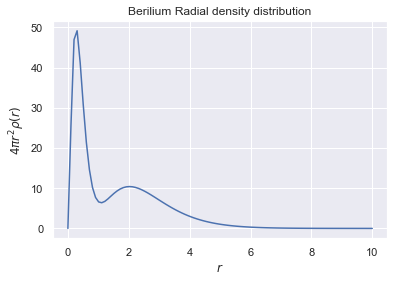

In [12]:

#Calling the exponents and coefficients for each atom:

#x = np.linspace(0,10,100)
##x=np.arange(0, 10, 0.01)
x = torch.linspace(0,10,100)
##x=np.arange(0, 10, 0.01)
plt.plot(x,4*np.pi*x*x*p_r_Beryllium(x))
plt.title('Berilium Radial density distribution')
plt.ylabel(r'$4\pi r^2\rho(r)$')
plt.xlabel(r'$r$')
#plt.show()
plt.savefig('beryllium_density.png', bbox_inches='tight', dpi=800)


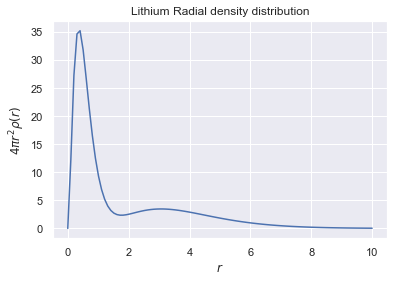

In [13]:
plt.plot(x,4*np.pi*x*x*p_r_Lithium(x))
plt.title('Lithium Radial density distribution')
plt.ylabel(r'$4\pi r^2\rho(r)$')
plt.xlabel(r'$r$')
#plt.show()
plt.savefig('lithium_density.png', bbox_inches='tight', dpi=800)

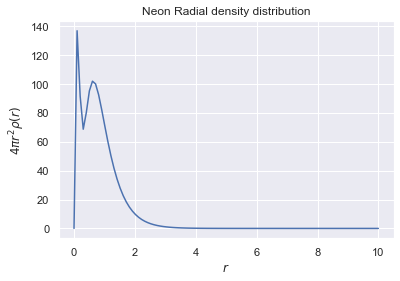

In [14]:
plt.plot(x,4*np.pi*x*x*p_r_Neon(x))
plt.title('Neon Radial density distribution')
plt.ylabel(r'$4\pi r^2\rho(r)$')
plt.xlabel(r'$r$')
#plt.show()
plt.savefig('neon_density.png', bbox_inches='tight', dpi=800)

The densities are named:
       
x is the point. 

p_r_Beryllium(x) for Beryllium
    
p_r_Lithium(x) for Lithium
    
p_r_Neon(x) for Neon


In [7]:
class Potential(nn.Module):
    def __init__(self):
        super(Potential,self).__init__()
        self.hidden0 = nn.Sequential(
            nn.Linear(1,64),
            nn.Tanh()
        )
        self.hidden1 = nn.Sequential(
            nn.Linear(64,128),
            nn.Tanh()
        )
        self.hidden2 = nn.Sequential(
            nn.Linear(128,128),
            nn.Tanh()
        )
        self.out = nn.Sequential(
            nn.Linear(128,1)
          
        )
        
    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        x = x + self.hidden2(x)
        x = 10*self.out(x)
        return x

In [8]:
potential = Potential()
optimizer = torch.optim.Adam(potential.parameters(), lr = .001, weight_decay=.0001)


<All keys matched successfully>

In [9]:
def new_prob_dist(batch, density):
    
    output = batch*torch.sqrt(density(batch))
    output.requires_grad_(True)
 
    potential_energy = potential(batch)
 
    first_der = grad(output, batch, grad_outputs = torch.ones_like(batch), 
                    create_graph=True, retain_graph=True, 
                   only_inputs=True,
                   allow_unused=True
                  )[0]
    kinetic_energy = grad(first_der, batch, grad_outputs = torch.ones_like(batch), 
                    create_graph=True, retain_graph=True, 
                   only_inputs=True,
                   allow_unused=True
                  )[0]
    conserve_energy = grad(kinetic_energy/(-2*output) + potential_energy, batch, grad_outputs = torch.ones_like(batch), 
                    create_graph=True, retain_graph=True, 
                   only_inputs=True,
                   allow_unused=True
                  )[0]
  
    return conserve_energy  


In [9]:
x_range = [0.1,10]
#Better to get from data
def sample_x(size):
    '''
    Uniform random x sampling within range
    '''
    x = (x_range[0] - x_range[1]) * torch.rand(size,1) + x_range[1]
    return x

In [10]:
class MyDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data.float()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        if self.transform:
            x = self.transform(x)
        return x

    def __len__(self):
        return len(self.data)

In [11]:
data = sample_x(5000)
dataset = MyDataset(data)
loader = DataLoader(dataset, batch_size = 64, shuffle = True)

In [13]:
###Doing each system at a time
num_epochs = 1000
loss = []
x = torch.tensor([1.0])
x.requires_grad_(True)
for epoch in range(num_epochs):
    error_batch = []
    for n_batch, batch in enumerate(loader):
        n_data = Variable(batch, requires_grad=True)
        optimizer.zero_grad()
        
       
        total_energy = new_prob_dist(n_data, p_r_Beryllium)**2 + (potential(x)+11.3424)**2 
      
      
        error = total_energy.mean() 
        
        error.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(potential.parameters(), 5.0)
      
        optimizer.step()
        error_batch.append(error.item())
    loss.append(np.mean(error_batch))
    print(loss[-1])
 


460.43791575371466
194.19386957868744
61.64083265051057
22.13283792175824
22.919015765190125
12.36631781089155
10.571345715583126
10.25399577919441
10.798239750386793
13.277213608162313
10.96454577921312
10.08107757945604
8.640460510797139
8.575112152325955
5.970308285725268
5.234152675429477
3.1653097215332564
4.069662131109758
5.516605370784108
4.069250758029992
2.1034862004880663
3.818165514995403
7.187118983532809
3.8364369233575046
1.5763308391729487
1.0637942413457586
2.83153326705664
2.0457283001440234
8.169294843485556
1.2311604047029079
4.481310275253616
2.4762746505910838
2.6987182875222797
2.383504288294647
2.13193569973677
1.9744976150414235
7.9880338277950695
4.376207767879661
1.1803627966702739
10.76496875215369
3.5827046610603603
1.6595698173240394
3.4374911938381345
3.167869451137472
1.6978395174292824
2.1866842807282376
3.2267982578258727
2.6859768991464676
2.4272982753412444
3.0753374049746536
3.4353560346880148
1.3623896144754901
4.290649218649804
4.787040709458951
1

KeyboardInterrupt: 

In [14]:
len(loss)

243

In [20]:
torch.save(potential.state_dict(), 'DFT_be.pkl')

In [15]:
def total_energy(batch, density):
    batch.requires_grad_(True)
    output = batch*torch.sqrt(density(batch))
    output.requires_grad_(True)
#     input_data = torch.stack([batch,output], dim=1).squeeze()
   
#     input_data.requires_grad_(True)
    potential_energy = potential(batch)
  
    first_der = grad(output, batch, grad_outputs = torch.ones_like(batch), 
                    create_graph=True, retain_graph=True, 
                   only_inputs=True,
                   allow_unused=True
                  )[0]
    kinetic_energy = grad(first_der, batch, grad_outputs = torch.ones_like(batch), 
                    create_graph=True, retain_graph=True, 
                   only_inputs=True,
                   allow_unused=True
                  )[0]
    return potential_energy + (kinetic_energy/(-2*output))
    

In [12]:
#not sure
def virial(batch, density):
    batch.requires_grad_(True)
    output = batch*torch.sqrt(density(batch))
    output.requires_grad_(True)
#     input_data = torch.stack([batch,output], dim=1).squeeze()
   
#     input_data.requires_grad_(True)
    potential_energy = potential(batch)
  
    first_der = grad(output, batch, grad_outputs = torch.ones_like(batch), 
                    create_graph=True, retain_graph=True, 
                   only_inputs=True,
                   allow_unused=True
                  )[0]
    kinetic_energy = grad(first_der, batch, grad_outputs = torch.ones_like(batch), 
                    create_graph=True, retain_graph=True, 
                   only_inputs=True,
                   allow_unused=True
                  )[0]
    return potential_energy/batch + (2* kinetic_energy)

In [16]:
sns.set()

In [13]:
test_data = torch.linspace(.2,10,1000).view(-1,1)

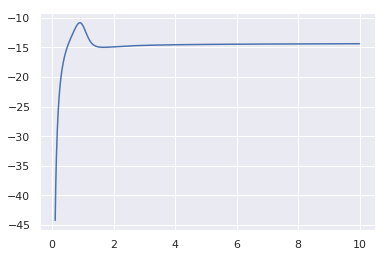

In [21]:
plt.plot(test_data.detach().numpy(), potential(test_data).detach().numpy())
plt.savefig('beryllium_potential.png', bbox_inches='tight', dpi=800)

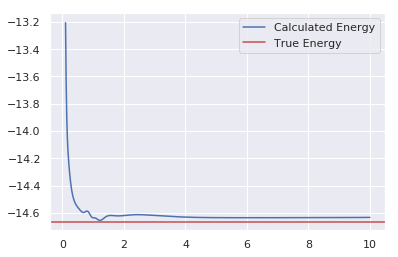

In [22]:
plt.plot(test_data.detach().numpy(), total_energy(test_data, p_r_Beryllium).detach().numpy(), label='Calculated Energy')
plt.axhline(y= - 14.666902, color='r', linestyle='-', label= 'True Energy')
plt.legend()
plt.savefig('beryllium_energy.png', bbox_inches='tight', dpi=800)

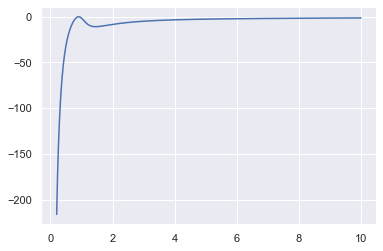

In [15]:
plt.plot(test_data.detach().numpy(), virali(test_data,p_r_Beryllium).detach().numpy())
plt.savefig('beryllium_virali.png', bbox_inches='tight', dpi=800)

In [18]:
virali(test_data,p_r_Beryllium).mean()

tensor(-3.2611, grad_fn=<MeanBackward0>)

In [23]:
total_energy(test_data, p_r_Beryllium).mean()

tensor(-14.6142, grad_fn=<MeanBackward0>)

(\nabla/-2 + V)\psi = E\psi
Dividing by \psi, we get (\nabla\psi)/(-2*psi) + V = E
V = E + \nabla\psi/(2*\psi)